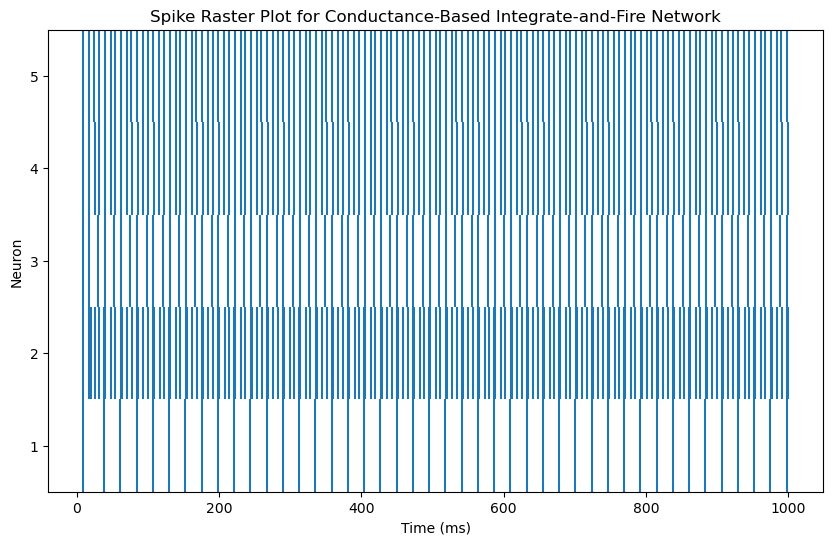

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation parameters
time_step = 0.1  # ms
total_time = 1000  # ms
num_neurons = 5
threshold = -50.0  # mV
reset_potential = -65.0  # mV
resting_potential = -65.0  # mV
time_constant = 10.0  # ms, reduced to speed up response

# Synaptic parameters
E_exc = 0.0    # mV, reversal potential for excitatory synapses
E_inh = -70.0  # mV, reversal potential for inhibitory synapses
tau_syn = 0.5  # ms, synaptic conductance decay time constant

# Higher external current to drive the network
input_current = np.full(num_neurons, 25.0)  # Increased external current

# Connectivity matrix (synaptic conductances)
g_max_matrix = np.array([   #cap at -10 to 10
    [0, -3.8, -0.2, -10, 0.54],
    [1.23, 0, -1.7, 10, -7.2],
    [-0.226, 0, 0, -10, 1.6],
    [-3.4, -5.7, -1.3, 0, 4.3],
    [-0.1, 1.5, 2.2, -10, 0]
])

# Initialize variables
membrane_potentials = np.full(num_neurons, resting_potential)
spike_times = [[] for _ in range(num_neurons)]
last_spike_time = np.full(num_neurons, -np.inf)
g_syn = np.zeros((num_neurons, num_neurons))  # Synaptic conductances

# Time vector
time_vector = np.arange(0, total_time, time_step)

# Simulation loop
for t_idx, t in enumerate(time_vector):
    # Update synaptic conductances
    g_syn *= np.exp(-time_step / tau_syn)
    
    # Calculate synaptic currents
    I_syn = np.zeros(num_neurons)
    for i in range(num_neurons):
        for j in range(num_neurons):
            if i != j:
                # Determine synapse type and reversal potential
                if g_max_matrix[i, j] > 0:
                    E_syn = E_exc
                else:
                    E_syn = E_inh
                I_syn[i] += g_syn[i, j] * (membrane_potentials[i] - E_syn)
    
    # Update membrane potentials
    dV = (-(membrane_potentials - resting_potential) - I_syn + input_current) * (time_step / time_constant)
    membrane_potentials += dV
    
    # Check for spikes
    for i in range(num_neurons):
        # Handle refractory period
        if t - last_spike_time[i] < 1.0:  # Short refractory period
            membrane_potentials[i] = reset_potential
            continue
        if membrane_potentials[i] >= threshold:
            spike_times[i].append(t)
            last_spike_time[i] = t
            membrane_potentials[i] = reset_potential  # Reset potential
            
            # Increase synaptic conductance for postsynaptic neurons
            for j in range(num_neurons):
                if i != j:
                    g_syn[j, i] += abs(g_max_matrix[j, i])  # Use absolute value

# Plot spikes
plt.figure(figsize=(10, 6))
for i in range(num_neurons):
    plt.vlines(spike_times[i], i + 0.5, i + 1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Neuron")
plt.yticks(np.arange(1, num_neurons + 1))
plt.title("Spike Raster Plot for Conductance-Based Integrate-and-Fire Network")
plt.ylim(0.5, num_neurons + 0.5)
plt.show()
